In [1]:
import numpy as np
import scipy as sci
import pandas as pd
import json
import ndjson
import jsonlines
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re
sys.path.append('..')
from ML import ml_utils

We will evaluate  construct the results tables here

## Data loading

In [2]:
path = os.path.join(*ml_utils.split_path_unix_win('../../Data/pan19-celebrity-profiling-training-dataset-2019-01-31/results/workset/creator'))
agen = 'age'
gendern = 'gender'
order = ['dist', 'char', 'asis', 'pos', 'tag', 'dep', 'lemma', 'word','emoticon_c','polarity', 'num']
order2 = []
for i in range(1, len(order)):
    order2.append('_'.join(order[0:i]))


# Data Set Distributions



In [22]:
prepr = re.sub('results', 'preprocessed', path)
def transformer(x):
    x['init_sum'] = sum(x['init_len'])
    x['n_tweets'] = len(x['init_len'])
    x['prepr_sum'] = sum(x['prepr_len'])

    return x
import gc
gc.collect()
if os.path.exists(os.path.join(prepr, 'ids_total.json')):
    ids = pd.read_json(os.path.join(prepr, 'ids_total.json'))
else:
    ids = None
    for tar in ['age', 'gender']:
        for leng in [100, 250, 500]:
            for aut in [50, 150, 500, 1000]:
                tmp_num = None
                for st in ['train', 'val', 'test']:
                    nfile = os.path.join(prepr, 'num', '{}'.format(leng), '{}'.format(tar),
                                         st, '{}_num_{}_{}_authors.ndjson'.format(st, leng, aut))

                    if type(tmp_num) == type(None):
                        with open(nfile, 'r', encoding='utf-8') as r:
                            tmp_num = pd.DataFrame(ndjson.load(r))
                            tmp_num.drop(labels=['mentions', 'tags', 'urls','times', 'tweetID',
                                                 'emotic_num', 'emojis_num', 'numericals', 'ID'], inplace=True, axis=1)

                            tmp_num['set'] = st
                            tmp_num = tmp_num.apply(func=transformer, axis=1)
                    else:
                        with open(nfile, 'r', encoding='utf-8') as r:
                            tmp = pd.DataFrame(ndjson.load(r))
                            tmp.drop(labels=['mentions', 'tags', 'urls','times', 'tweetID',
                                                 'emotic_num', 'emojis_num', 'numericals', 'ID'], inplace=True, axis=1)

                            tmp['set'] = st
                            tmp = tmp.apply(func=transformer, axis=1)
                            tmp_num = pd.concat([tmp_num, tmp], axis=0)


                file = os.path.join(prepr, '{}_ids'.format(tar),
                                                'ids_{}_{}_{}_authors_balanced.json').format(tar, leng, aut)
                print(file)
                tmp = pd.read_json(file)
                tmp['target'] = tar
                tmp['No. of Authors'] = aut
                tmp['No. of Characters'] = leng
                tmp = tmp.merge(tmp_num, how='left', left_on='uID', right_on='uID')
                if type(ids)==type(None):
                    ids = tmp
                else:
                    ids = pd.concat([ids, tmp], axis=0)
    ids = ids.reset_index(drop=True)

    ids.to_json(os.path.join(prepr, 'ids_total.json'))

In [23]:
ids.rename(columns={'# Authors':'No. of Authors',
                    '# Chars in Input': 'No. of Characters'}, inplace=True)
ids.head()

ID               tweetID                uID  centered_age gender  \
0  14544             [14544_5]            14544_5          1985   male   
1  14544             [14544_6]            14544_6          1985   male   
2  14544   [14544_9, 14544_10]   14544_9|14544_10          1985   male   
3  14544  [14544_11, 14544_12]  14544_11|14544_12          1985   male   
4  14544            [14544_13]           14544_13          1985   male   

   birthyear      strat target  No. of Authors  No. of Characters  init_len  \
0       1984  1985_male    age              50                100     [142]   
1       1984  1985_male    age              50                100     [140]   
2       1984  1985_male    age              50                100  [47, 53]   
3       1984  1985_male    age              50                100  [99, 70]   
4       1984  1985_male    age              50                100     [116]   

    prepr_len    set  init_sum  n_tweets  prepr_sum  
0       [159]   test       142         1        159  
1       [165]   test       140         1        165  
2    [29, 74]  train       100         2        103  
3  [132, 103]   test       169         2        235  
4       [144]    val       116         1        144

In [24]:
def aggregate(x):
    d = {}
    tot =  x['init_sum'].sum()
    tsum = x['n_tweets'].sum()
    d['avg_tweet'] = round(tot/tsum,2)
    d['avg_instance'] = round(tot/x.shape[0],2)
    d['avg_tweet_per_instance'] = round(tsum/x.shape[0],2)
    return pd.Series(d, index=['avg_instance', 'avg_tweet', 'avg_tweet_per_instance'])

In [25]:
grouped = ids.groupby(by=['target', 'No. of Characters', 'No. of Authors']).apply(aggregate)
grouped = grouped.reset_index()
grouped = pd.pivot(index=[ 'No. of Characters','No. of Authors'], columns=['target'],
                   values=['avg_instance', 'avg_tweet', 'avg_tweet_per_instance'], data=grouped)



grouped

avg_instance         avg_tweet          \
target                                    age  gender       age  gender   
No. of Characters No. of Authors                                          
100               50                   160.30  162.94    109.58  111.92   
                  150                  160.52  162.37    107.38  112.94   
                  500                  160.78  161.63    109.21  111.86   
                  1000                 160.07  160.99    109.28  111.84   
250               50                   313.16  315.73    109.05  112.02   
                  150                  313.25  315.58    107.43  112.84   
                  500                  313.26  314.66    109.09  111.67   
                  1000                 313.30  314.34    109.18  111.84   
500               50                   565.60  568.76    109.12  111.87   
                  150                  565.89  568.71    107.48  112.84   
                  500                  566.13  567.54    109.15  111.70   
                  1000                 566.10  567.38    109.17  111.85   

                                 avg_tweet_per_instance         
target                                              age gender  
No. of Characters No. of Authors                                
100               50                               1.46   1.46  
                  150                              1.49   1.44  
                  500                              1.47   1.44  
                  1000                             1.46   1.44  
250               50                               2.87   2.82  
                  150                              2.92   2.80  
                  500                              2.87   2.82  
                  1000                             2.87   2.81  
500               50                               5.18   5.08  
                  150                              5.27   5.04  
                  500                              5.19   5.08  
                  1000                             5.19   5.07

In [26]:
savedir = os.path.join(*ml_utils.split_path_unix_win('../../tex/tables'))
table = grouped.to_latex(sparsify=True,
                         multirow=True,
                         multicolumn=True,
                        caption='''Statistics of the Dataset''',
                         label='tab:dataset',
                         float_format="%.2f")
table = re.sub(r'begin{table}', 'begin{table}[!ht]', table)
table = re.sub('& target &', '& Target &', table)
table = re.sub('& tweetLen &', r'& Min. \\No. of Characters &', table)
table = re.sub(r"\\begin\{tabular", r"\\begin{adjustbox}{max width=\\textwidth}\n\\begin{tabular", table)
table = re.sub(r"\\end\{tabular}", r"\n\\end{tabular}\\end{adjustbox}", table)

with open(os.path.join(savedir, 'dataset.tex'), 'w') as w:
    w.write(table)

In [27]:
grouped = ids.groupby(by=['set','target', 'No. of Characters', 'No. of Authors']).apply(aggregate)
grouped = grouped.reset_index()
grouped.head()

set target  No. of Characters  No. of Authors  avg_instance  avg_tweet  \
0  test    age                100              50        159.93     109.42   
1  test    age                100             150        161.05     107.75   
2  test    age                100             500        160.74     109.27   
3  test    age                100            1000        160.09     109.28   
4  test    age                250              50        313.19     108.30   

   avg_tweet_per_instance  
0                    1.46  
1                    1.49  
2                    1.47  
3                    1.47  
4                    2.89

In [28]:
for st in ['train', 'val', 'test']:
    pv = pd.pivot(index=[ 'No. of Characters','No. of Authors'], columns=['target'],
                       values=['avg_instance', 'avg_tweet', 'avg_tweet_per_instance'],
                       data=grouped.loc[grouped.set == st,:])



    savedir = os.path.join(*ml_utils.split_path_unix_win('../../tex/tables'))
    table = pv.to_latex(sparsify=True,
                             multirow=True,
                             multicolumn=True,
                            caption='''Statistics of the Dataset''',
                             label='tab:dataset_{}'.format(st),
                             float_format="%.2f")
    table = re.sub(r'begin{table}', 'begin{table}[!ht]', table)
    table = re.sub('& target &', '& Target &', table)
    table = re.sub('& tweetLen &', r'& Min. No. of Characters &', table)
    table = re.sub(r"\\begin\{tabular", r"\\begin{adjustbox}{max width=\\textwidth}\n\\begin{tabular", table)
    table = re.sub(r"\\end\{tabular}", r"\n\\end{tabular}\\end{adjustbox}", table)

    with open(os.path.join(savedir, '{}_dataset.tex'.format(st)), 'w') as w:
        w.write(table)

In [11]:
del ids
gc.collect()

508

In [3]:

age_files = {'acc':[], 'dist': []}
gender_files = {'acc':[], 'dist': []}
for file in os.listdir(os.path.join(path, agen)):

    if os.path.isfile(os.path.join(path, agen, file)):
        if 'scores' in file:
            age_files['acc'].append(file)
        else:
            age_files['dist'].append(file)

for file in os.listdir(os.path.join(path, gendern)):
    if os.path.isfile(os.path.join(path, gendern, file)):
        if 'scores' in file:
            gender_files['acc'].append(file)
        else:
            gender_files['dist'].append(file)

age_acc = None
for file in age_files['acc']:
    if 'cwal_' in file:
        print(file)
        continue
    lines = []
    f = open(os.path.join(path, agen, file), 'r')
    for line in f.readlines():
        lines.append(json.loads(line))
    f.close()
    tmp = pd.DataFrame.from_records(lines)
    tmp.subgrams = tmp['subgrams'].apply( lambda x: '-'.join([str(el) for el in x]))
    #tmp['target'] = 'age'
    if 'baseline' in file or 'singular' in file:
        tmp['set'] = 'singular'
        tmp['set_enum'] = 1
        tmp['set_feat'] = 'all'
        tmp['modeltype'] = 'baseline'
    elif 'cwald' in file:
        tmp['set'] = 'dist-char-word-lemma'
        tmp['set_enum'] =2
        tmp['set_feat'] = 'DIST-CHAR-WORD-LEMMA'
    else:
        tmp['set'] = 'ordered-full'
        tmp['set_enum'] = 3
        tmp['set_feat'] = 'all'
    if type(age_acc) == type(None):
        age_acc = tmp
    else:

        age_acc = pd.concat([age_acc, tmp], axis=0)

colnames = [el for el in age_acc.columns.values if el not in ['f1-score', 'accuracy']]
print(age_acc[age_acc.duplicated(colnames)])
age_acc.drop_duplicates(colnames, inplace=True)
age_acc.loc[age_acc.modeltype == 'direct',['modeltype']] = 'cumulated'
age_acc.loc[age_acc.modeltype == 'dynAA',['modeltype']] = 'stacked'

age_dist = None
for file in age_files['dist']:
    if 'cwal_' in file:
        continue
    lines = []
    f = open(os.path.join(path, agen, file), 'r')
    for line in f.readlines():
        lines.append(json.loads(line))
    f.close()
    tmp = pd.DataFrame.from_records(lines)
    tmp.subgrams = tmp['subgrams'].apply( lambda x: '-'.join([str(el) for el in x]))
    #tmp['target'] = 'age'
    if 'baseline' in file or 'singular' in file:
        tmp['set'] = 'singular'
        tmp['set_enum'] = 1
        tmp['set_feat'] = 'all'
        tmp['modeltype'] = 'baseline'
    elif 'cwald' in file:
        tmp['set'] = 'dist-char-word-lemma'
        tmp['set_enum'] =2
        tmp['set_feat'] = 'DIST-CHAR-WORD-LEMMA'
    else:
        tmp['set'] = 'ordered-full'
        tmp['set_enum'] = 3
        tmp['set_feat'] = 'all'
    if type(age_dist) == type(None):
        age_dist = tmp
    else:
        age_dist = pd.concat([age_dist, tmp], axis=0)
colnames = [el for el in age_dist.columns.values if el not in ["Average Spearman's Rho (ext.)",
                                                      "Average Spearman's Rho (red.)"]]
age_dist.drop_duplicates(colnames, inplace=True)
print(age_dist.shape)
print(age_acc.shape)
#age = age_acc.merge(age_dist.loc[:, ['set', 'tweetLen', 'No. of Authors','rank',
#                             'featuretypes', 'modeltype', 'target',
#                             "Average Spearman's Rho (ext.)",
 #                            "Average Spearman's Rho (red.)"]], how='left')

#set NaNs in Spearman always for first iteration, where there is not yet a comparison and thus no distortion to '-'

#age.loc[age["Average Spearman's Rho (ext.)"].isna(), ["Average Spearman's Rho (ext.)",
#                                                      "Average Spearman's Rho (red.)"]] = '-'


age_dist.loc[age_dist.modeltype == 'direct',['modeltype']] = 'cumulated'
age_dist.loc[age_dist.modeltype == 'dynAA',['modeltype']] = 'stacked'
age_dist.head()

cwal_100_basic_scores.ndjson
                                          featuretypes  # Authors subgrams  \
36                                            emoticon         50        1   
39                                            emoticon        150        1   
42                                            emoticon         50        1   
49                                            emoticon        150        1   
51                                            emoticon         50        1   
..                                                 ...        ...      ...   
750  dist_char_asis_pos_tag_dep_lemma_word_emoticon...        500        1   
751  dist_char_asis_pos_tag_dep_lemma_word_emoticon...        500        1   
803  dist_char_asis_pos_tag_dep_lemma_word_emoticon...        500        1   
823  dist_char_asis_pos_tag_dep_lemma_word_emoticon...        500        1   
824  dist_char_asis_pos_tag_dep_lemma_word_emoticon...        500        1   

    modeltype        name  tweetLe

featuretypes  # Authors subgrams  modeltype    name  tweetLen target   rank  \
0         dist        150        2  cumulated  dist 2       500    age     02   
1         dist        150      2-3  cumulated  dist 3       500    age    023   
2         dist        150    2-3-4  cumulated  dist 4       500    age   0234   
3         dist        150  2-3-4-5  cumulated  dist 5       500    age  02345   
4    dist_char        150        2    stacked  char 2       500    age    012   

   Average Spearman's Rho (ext.)  Average Spearman's Rho (red.)  \
0                       0.187245                       0.072675   
1                       0.114232                       0.035884   
2                       0.026844                       0.015722   
3                       0.021929                       0.006432   
4                       0.073347                       0.022784   

                    set  set_enum              set_feat  
0  dist-char-word-lemma         2  DIST-CHAR-WORD-LEMMA  
1  dist-char-word-lemma         2  DIST-CHAR-WORD-LEMMA  
2  dist-char-word-lemma         2  DIST-CHAR-WORD-LEMMA  
3  dist-char-word-lemma         2  DIST-CHAR-WORD-LEMMA  
4  dist-char-word-lemma         2  DIST-CHAR-WORD-LEMMA

In [4]:
#make the same frame for gender
gender_acc = None
for file in gender_files['acc']:
    if 'cwal_' in file:
        continue
    lines = []
    f = open(os.path.join(path, gendern, file), 'r')
    for line in f.readlines():
        lines.append(json.loads(line))
    f.close()
    tmp = pd.DataFrame.from_records(lines)
    if tmp.shape[0]==0:
        continue
    #print(tmp.columns.values)
    tmp.subgrams = tmp['subgrams'].apply( lambda x: '-'.join([str(el) for el in x]))
    #tmp['target'] = 'gender'
    if 'baseline' in file or 'singular' in file:
        tmp['set'] = 'singular'
        tmp['set_enum'] = 1
        tmp['set_feat'] = 'all'
        tmp['modeltype'] = 'baseline'
    elif 'cwald' in file:
        tmp['set'] = 'dist-char-word-lemma'
        tmp['set_enum'] =2
        tmp['set_feat'] = 'DIST-CHAR-WORD-LEMMA'
    else:
        tmp['set'] = 'ordered-full'
        tmp['set_enum'] = 3
        tmp['set_feat'] = 'all'
    if type(gender_acc) == type(None):
        gender_acc = tmp
    else:

        gender_acc = pd.concat([gender_acc, tmp], axis=0)

colnames = [el for el in gender_acc.columns.values if el not in ['f1-score', 'accuracy']]
print(gender_acc[gender_acc.duplicated(colnames)])
gender_acc.drop_duplicates(colnames, inplace=True)
gender_acc.loc[gender_acc.modeltype == 'direct',['modeltype']] = 'cumulated'
gender_acc.loc[gender_acc.modeltype == 'dynAA',['modeltype']] = 'stacked'

gender_dist = None
for file in gender_files['dist']:
    if 'cwal_' in file:
        continue
    lines = []
    f = open(os.path.join(path, gendern, file), 'r')
    for line in f.readlines():
        lines.append(json.loads(line))
    f.close()
    tmp = pd.DataFrame.from_records(lines)
    tmp.subgrams = tmp['subgrams'].apply( lambda x: '-'.join([str(el) for el in x]))
    #tmp['target'] = 'gender'
    if 'baseline' in file or 'singular' in file:
        tmp['set'] = 'singular'
        tmp['set_enum'] = 1
        tmp['set_feat'] = 'all'
        tmp['modeltype'] = 'baseline'
    elif 'cwald' in file:
        tmp['set'] = 'dist-char-word-lemma'
        tmp['set_enum'] =2
        tmp['set_feat'] = 'DIST-CHAR-WORD-LEMMA'
    else:
        tmp['set'] = 'ordered-full'
        tmp['set_enum'] = 3
        tmp['set_feat'] = 'all'
    if type(gender_dist) == type(None):
        gender_dist = tmp
    else:
        gender_dist = pd.concat([gender_dist, tmp], axis=0)

colnames = [el for el in gender_dist.columns.values if el not in ["Average Spearman's Rho (ext.)",
                                                      "Average Spearman's Rho (red.)"]]
print(gender_dist[gender_dist.duplicated(colnames)])
gender_dist.drop_duplicates(colnames, inplace=True)

print(gender_dist.shape)
print(gender_acc.shape)
#gender = gender_acc.merge(gender_dist.loc[:, ['set', 'tweetLen', 'No. of Authors','rank',
#                             'featuretypes', 'modeltype', 'target',
#                             "Average Spearman's Rho (ext.)",
#                             "Average Spearman's Rho (red.)"]], how='left')

#set NaNs in Spearman always for first iteration, where there is not yet a comparison and thus no distortion to '-'

#gender.loc[gender["Average Spearman's Rho (ext.)"].isna(), ["Average Spearman's Rho (ext.)",
#                                                      "Average Spearman's Rho (red.)"]] = '-'

gender_dist.loc[gender_dist.modeltype == 'direct',['modeltype']] = 'cumulated'
gender_dist.loc[gender_dist.modeltype == 'dynAA',['modeltype']] = 'stacked'
gender_dist.head()


                                          featuretypes  # Authors subgrams  \
15                                            emoticon         50        1   
26                                            emoticon         50        1   
27                                            emoticon         50        1   
32                                            emoticon        150        1   
49                                            emoticon        150        1   
..                                                 ...        ...      ...   
735  dist_char_asis_pos_tag_dep_lemma_word_emoticon...        500        1   
740  dist_char_asis_pos_tag_dep_lemma_word_emoticon...        500        1   
754  dist_char_asis_pos_tag_dep_lemma_word_emoticon...        500        1   
755  dist_char_asis_pos_tag_dep_lemma_word_emoticon...        500        1   
763  dist_char_asis_pos_tag_dep_lemma_word_emoticon...        500        1   

    modeltype        name  tweetLen  target             rank  a

featuretypes  # Authors subgrams  modeltype    name  tweetLen  target  \
0         dist        150        2  cumulated  dist 2       500  gender   
1         dist        150      2-3  cumulated  dist 3       500  gender   
2         dist        150    2-3-4  cumulated  dist 4       500  gender   
3         dist        150  2-3-4-5  cumulated  dist 5       500  gender   
4    dist_char        150        2    stacked  char 2       500  gender   

    rank  Average Spearman's Rho (ext.)  Average Spearman's Rho (red.)  \
0     02                       0.085755                       0.136993   
1    023                       0.153513                       0.113376   
2   0234                       0.118509                      -0.005042   
3  02345                       0.090370                       0.054982   
4    012                       0.127436                       0.053515   

                    set  set_enum              set_feat  
0  dist-char-word-lemma         2  DIST-CHAR-WORD-LEMMA  
1  dist-char-word-lemma         2  DIST-CHAR-WORD-LEMMA  
2  dist-char-word-lemma         2  DIST-CHAR-WORD-LEMMA  
3  dist-char-word-lemma         2  DIST-CHAR-WORD-LEMMA  
4  dist-char-word-lemma         2  DIST-CHAR-WORD-LEMMA

In [51]:
dist = pd.concat([age_dist, gender_dist])
acc = pd.concat([age_acc, gender_acc])
dist.rename(columns={'# Authors':'No. of Authors'}, inplace=True)
acc.rename(columns={'# Authors':'No. of Authors'}, inplace=True)

In [52]:
dist.columns

Index(['featuretypes', 'No. of Authors', 'subgrams', 'modeltype', 'name',
       'tweetLen', 'target', 'rank', 'Average Spearman's Rho (ext.)',
       'Average Spearman's Rho (red.)', 'set', 'set_enum', 'set_feat'],
      dtype='object')

In [53]:
df = dist.copy()
ids = [el for el in df.columns.to_list() if el not in ['accuracy', 'f1-score',
                                                             "Average Spearman's Rho (ext.)",
                                                             "Average Spearman's Rho (red.)"]]
df = pd.melt(df, id_vars=ids, var_name='Score', value_name='result')
df.head()
ranks = df['rank']
df = df.drop(['rank', 'name'], axis=1)
#sub.columns = pd.MultiIndex.from_product([sub['tweetLen'], sub['No. of Authors'], sub['Type']])
piv = df.pivot(index=['set','modeltype','featuretypes', 'subgrams'],
               columns=['target','tweetLen', 'No. of Authors', 'Score'], values='result')
piv

target                                                                         age  \
tweetLen                                                                       500   
No. of Authors                                                                150    
Score                                                Average Spearman's Rho (ext.)   
set                  modeltype featuretypes subgrams                                 
dist-char-word-lemma cumulated dist         2                             0.187245   
                                            2-3                           0.114232   
                                            2-3-4                         0.026844   
                                            2-3-4-5                       0.021929   
                               dist_char    2                             0.136581   
...                                                                            ...   
singular             baseline  tag          1                             0.088622   
                                            1-2                           0.017799   
                                            1-2-3                         0.082513   
                               word         1                            -0.058514   
                                            1-2                          -0.011166   

target                                                                              \
tweetLen                                                                       250   
No. of Authors                                                                150    
Score                                                Average Spearman's Rho (ext.)   
set                  modeltype featuretypes subgrams                                 
dist-char-word-lemma cumulated dist         2                             0.041580   
                                            2-3                          -0.022333   
                                            2-3-4                         0.002778   
                                            2-3-4-5                       0.004039   
                               dist_char    2                             0.061984   
...                                                                            ...   
singular             baseline  tag          1                            -0.018548   
                                            1-2                           0.045190   
                                            1-2-3                         0.040029   
                               word         1                            -0.118380   
                                            1-2                          -0.068614   

target                                                                              \
tweetLen                                                                       100   
No. of Authors                                                                150    
Score                                                Average Spearman's Rho (ext.)   
set                  modeltype featuretypes subgrams                                 
dist-char-word-lemma cumulated dist         2                             0.034811   
                                            2-3                          -0.005109   
                                            2-3-4                        -0.003334   
                                            2-3-4-5                       0.021338   
                               dist_char    2                             0.001302   
...                                                                            ...   
singular             baseline  tag          1                             0.113389   
                                            1-2                           0.064695   
                                            1-2-3                         0.033945   
                               word       

In [54]:
#get all levels with unique values
#piv.reindex(order, level=0).loc[:, (100, [50,150,500,1000], ['accuracy', 'f1-score'])]
sets = piv.index.unique(level=0).values.tolist()
modeltypes = piv.index.unique(level=1).values.tolist()

targets = piv.columns.unique(level=0).values.tolist()
tweetLens = piv.columns.unique(level=1).values.tolist()
authors = piv.columns.unique(level=2).values.tolist()
scores = piv.columns.unique(level=3).values.tolist()
sets



['dist-char-word-lemma', 'ordered-full', 'singular']

In [55]:
def rep(x):
    return re.sub('r', 'c', x.group(0))
pat = re.compile(r"\{llr+", re.ASCII)
savedir = os.path.join(*ml_utils.split_path_unix_win('../../tex/tables'))
scoresets = {'dist':scores[0:]}
for st in sets:
    for modeltype in piv.loc[st, :].index.unique(level=0):
        for target in targets:
            for tweetLen in tweetLens:
                for key in scoresets.keys():
                    score_package = scoresets[key]
                    tmp = piv.loc[(st, modeltype), (target, tweetLen, [50,150,500,1000], score_package)]
                    if st == 'singular':
                        tmp = tmp.reindex(order, level=0)
                    elif st =='dist-char-word-lemma':
                        tmp = tmp.reindex(['dist', 'dist_char', 'dist_char_asis',
                                           'dist_char_asis_lemma', 'dist_char_asis_lemma_word'], level=0)
                    else:
                        tmp = tmp.reindex(order2, level=0)
                    #print(tmp.head())
                    #make text parts for captions modeltype
                    if 'stacked' in modeltype:
                        mod = 'stacked'
                        l1 = 'dynAA'
                    elif 'cumulated' in modeltype:
                        mod = 'cumulated'
                        l1 = 'direct'
                    elif 'baseline' in modeltype:
                        mod = 'feature-wise'
                        l1 = 'baseline'
                    if 'ordered-full' in st:
                        featureset = 'ordered, full feature set'
                        l2 = 'full'
                    elif 'singular' in st:
                        featureset = 'individual feature types'
                        l2 = 'individual'
                        tmp = tmp.drop(labels=('polarity'), level=0, axis=0)
                    elif 'dist-char' in st:
                        featureset = r'reduced feature set (DIST, CHAR, LEMMA, WORD)'
                        l2='dwald'
                    if key == 'acc':
                        sc = 'Accuracy and F1-scores'
                    elif key == 'f1_dist':
                        sc = 'F1-scores & stability of feature relevance'
                    else:
                        sc = 'Stability of feature relevance'
                    tmp.index = tmp.index.set_levels([el.upper() for el in tmp.index.levels[0]], level=0)
                    os.makedirs(os.path.join(savedir, target, 'latex'), exist_ok=True)
                    os.makedirs(os.path.join(savedir, target, 'html'), exist_ok=True)
                    file_h = os.path.join(savedir, target, 'html', 'results_{}_{}_{}_{}_{}.html'.format(target, l2, l1,
                                                                                            tweetLen, key))
                    file_t = os.path.join(savedir, target, 'latex', 'results_{}_{}_{}_{}_{}.tex'.format(target, l2, l1,
                                                                                            tweetLen, key))
                    with open(file_h, 'w') as w:
                        tmp.to_html(w, sparsify=True)
                    with open(file_t, 'w') as w:
                        table = tmp.to_latex(sparsify=True, multirow=True, multicolumn=True,
                                        caption='''{} for the prediction of {} on a minimal input instance
                                        length of {} characters using a {} model on the {}'''.format(sc, target, tweetLen, mod, featureset),
                                     label='tab:{}_{}_{}_{}_{}'.format(target[0].upper()+target[1:], key, tweetLen, l1,l2),
                                     float_format="%.4f")
                        #table = re.sub(r'{table}', '{sidewaystable}', table)
                        table = re.sub(r'begin{table}', 'begin{table}[!ht]', table)
                        #table = re.sub(r'\\begin\{table}', '', table)
                        #table = re.sub(r'\\end\{table}', '', table)
                        table = re.sub("Average Spearman's Rho \(ext.\)",
                                        r"\\thead{Avg. \\\\ Spearman's $\\rho$ (ext.)}", table)
                        table = re.sub("Average Spearman's Rho \(red.\)",
                                        r"\\thead{Avg. \\\\ Spearman's  $\\rho$ (red.)}", table)
                        table = re.sub('& target &', '& Target &', table)
                        table = re.sub('feature types &', 'Feature types &', table)
                        table = re.sub('featuretypes &', 'Feature types &', table)
                        table = re.sub('& subgrams &', '& N-gram ranges &', table)
                        table = re.sub('& tweetLen &', r'& Min. No. of Characters &', table)
                        table = re.sub('& f1-score', '& F1-score', table)
                        table = re.sub('& accuracy', '& Accuracy', table)
                        table = re.sub(r'\{age}', '{Age}', table)
                        table = re.sub(r'\{gender}', '{Gender}', table)
                        table = re.sub(pat,rep, table)
                        table = re.sub(r"\\begin\{tabular", r"\\begin{adjustbox}{max width=\\textwidth}\n\\begin{tabular", table)
                        table = re.sub(r"\\end\{tabular}", r"\n\\end{tabular}\\end{adjustbox}", table)
                        table = re.sub(r"0\.0000", '--', table)
                            #print(table)
                        w.write(table)

In [56]:
os.getcwd()

'C:\\Users\\schubert\\Documents\\attributionfeatures\\Scripts\\Evaluation'

In [57]:
df = acc.copy()

ids = [el for el in df.columns.to_list() if el not in ['accuracy', 'f1-score',
                                                             "Average Spearman's Rho (ext.)",
                                                             "Average Spearman's Rho (red.)"]]
df = pd.melt(df, id_vars=ids, var_name='Score', value_name='result')
df.head()
ranks = df['rank']
df = df.drop(['rank', 'name'], axis=1)
#sub.columns = pd.MultiIndex.from_product([sub['tweetLen'], sub['No. of Authors'], sub['Type']])
piv = df.pivot(index=['set','modeltype','featuretypes', 'subgrams'], columns=['target','tweetLen', 'No. of Authors', 'Score'], values='result')
piv

target                                                       age            \
tweetLen                                                     250       500   
No. of Authors                                              50        50     
Score                                                   accuracy  accuracy   
set                  modeltype featuretypes   subgrams                       
dist-char-word-lemma cumulated dist_char      2         0.677175  0.726180   
                                              2-3       0.762708  0.819234   
                                              2-3-4     0.753421  0.832146   
                                              2-3-4-5   0.738025  0.823241   
                               dist_char_asis 2         0.774927  0.850846   
...                                                          ...       ...   
singular             baseline  tag            1         0.345308  0.408281   
                                              1-2       0.507087  0.547640   
                                              1-2-3     0.522483  0.587711   
                               word           1         0.499756  0.628228   
                                              1-2       0.509286  0.643811   

target                                                                      \
tweetLen                                                     250       100   
No. of Authors                                              150       50     
Score                                                   accuracy  accuracy   
set                  modeltype featuretypes   subgrams                       
dist-char-word-lemma cumulated dist_char      2         0.577151  0.598279   
                                              2-3       0.668444  0.690742   
                                              2-3-4     0.670665  0.703102   
                                              2-3-4-5   0.684733  0.680441   
                               dist_char_asis 2         0.699319  0.716069   
...                                                          ...       ...   
singular             baseline  tag            1         0.286687  0.263936   
                                              1-2       0.371761  0.419535   
                                              1-2-3     0.394713  0.448255   
                               word           1         0.408485  0.419292   
                                              1-2       0.423590  0.427412   

target                                                                      \
tweetLen                                                               500   
No. of Authors                                              150       1000   
Score                                                   accuracy  accuracy   
set                  modeltype featuretypes   subgrams                       
dist-char-word-lemma cumulated dist_char      2         0.488672  0.446504   
                                              2-3       0.559526  0.519917   
                                              2-3-4     0.574910  0.543726   
                                              2-3-4-5   0.537784  0.545106   
                               dist_char_asis 2         0.582840  0.556557   
...                                                          ...       ...   
singular             baseline  tag            1         0.215523  0.229119   
                                              1-2       0.297047  0.299792   
                                              1-2-3     0.342469  0.340174   
                               word           1         0.300994  0.352343   
                                              1-2       0.316853  0.355102   

target                                                                      \
tweetLen                                                     250       500   
No. of Authors                                              500       500    
Score              

In [58]:
#get all levels with unique values
#piv.reindex(order, level=0).loc[:, (100, [50,150,500,1000], ['accuracy', 'f1-score'])]
sets = piv.index.unique(level=0).values.tolist()
modeltypes = piv.index.unique(level=1).values.tolist()

targets = piv.columns.unique(level=0).values.tolist()
tweetLens = piv.columns.unique(level=1).values.tolist()
authors = piv.columns.unique(level=2).values.tolist()
scores = piv.columns.unique(level=3).values.tolist()
sets


['dist-char-word-lemma', 'ordered-full', 'singular']

In [59]:
savedir = os.path.join(*ml_utils.split_path_unix_win('../../tex/tables'))
scoresets = {'acc':scores[0:2]}
for st in sets:
    for modeltype in piv.loc[st, :].index.unique(level=0):
        for target in targets:
            for tweetLen in tweetLens:
                for key in scoresets.keys():
                    score_package = scoresets[key]
                    tmp = piv.loc[(st, modeltype), (target, tweetLen, [50,150,500,1000], score_package)]
                    if st == 'singular':
                        tmp = tmp.reindex(order, level=0)
                    elif st =='dist-char-word-lemma':
                        tmp = tmp.reindex(['dist', 'dist_char', 'dist_char_asis',
                                           'dist_char_asis_lemma', 'dist_char_asis_lemma_word'], level=0)
                    else:
                        tmp = tmp.reindex(order2, level=0)
                    #print(tmp.head())
                    #make text parts for captions modeltype
                    if 'stacked' in modeltype:
                        mod = 'stacked'
                        l1 = 'dynAA'
                    elif 'cumulated' in modeltype:
                        mod = 'cumulated'
                        l1 = 'direct'
                    elif 'baseline' in modeltype:
                        mod = 'feature-wise'
                        l1 = 'baseline'
                    if 'ordered-full' in st:
                        featureset = 'ordered, full feature set'
                        l2 = 'full'
                    elif 'singular' in st:
                        featureset = 'individual feature types'
                        l2 = 'individual'
                        tmp = tmp.drop(labels=('polarity'), level=0, axis=0)
                    elif 'dist-char' in st:
                        featureset = r'reduced feature set (DIST, CHAR, LEMMA, WORD)'
                        l2='dwald'
                    if key == 'acc':
                        sc = 'Accuracy and F1-scores'
                    elif key == 'f1_dist':
                        sc = 'F1-scores & stability of feature relevance'
                    else:
                        sc = 'Stability of feature relevance'
                    tmp.index = tmp.index.set_levels([el.upper() for el in tmp.index.levels[0]], level=0)
                    os.makedirs(os.path.join(savedir, target, 'latex'), exist_ok=True)
                    os.makedirs(os.path.join(savedir, target, 'html'), exist_ok=True)
                    file_h = os.path.join(savedir, target, 'html', 'results_{}_{}_{}_{}_{}.html'.format(target, l2, l1,
                                                                                            tweetLen, key))
                    file_t = os.path.join(savedir, target, 'latex', 'results_{}_{}_{}_{}_{}.tex'.format(target, l2, l1,
                                                                                            tweetLen, key))
                    with open(file_h, 'w') as w:
                        tmp.to_html(w, sparsify=True)
                    with open(file_t, 'w') as w:
                        table = tmp.to_latex(sparsify=True, multirow=True, multicolumn=True,
                                        caption='''{} for the prediction of {} on a minimal input instance
                                        length of {} characters using a {} model on the {}'''.format(sc, target, tweetLen, mod, featureset),
                                     label='tab:{}_{}_{}_{}_{}'.format(target[0].upper()+target[1:], key, tweetLen, l1,l2),
                                     float_format="%.4f")

                        #table = re.sub(r'{table}', '{sidewaystable}', table)
                        table = re.sub(r'begin{table}', 'begin{table}[!ht]', table)
                        #table = re.sub(r'\\begin\{table}', '', table)
                        #table = re.sub(r'\\end\{table}', '', table)
                        table = re.sub("Average Spearman's Rho \(ext.\)",
                                        r"\\thead{Avg. \\\\ Spearman's $\\rho$ (ext.)}", table)
                        table = re.sub("Average Spearman's Rho \(red.\)",
                                        r"\\thead{Avg. \\\\ Spearman's  $\\rho$ (red.)}", table)
                        table = re.sub('& target &', '& Target &', table)
                        table = re.sub('feature types &', 'Feature types &', table)
                        table = re.sub('featuretypes &', 'Feature types &', table)
                        table = re.sub('& subgrams &', '& N-gram ranges &', table)
                        table = re.sub('& tweetLen &', r'& Min. No. of Characters &', table)
                        table = re.sub('& f1-score', '& F1-score', table)
                        table = re.sub('& accuracy', '& Accuracy', table)
                        table = re.sub(r'\{age}', '{Age}', table)
                        table = re.sub(r'\{gender}', '{Gender}', table)
                        table = re.sub(pat,rep, table)
                        table = re.sub(r"\\begin\{tabular", r"\\begin{adjustbox}{max width=\\textwidth}\n\\begin{tabular", table)
                        table = re.sub(r"\\end\{tabular}", r"\n\\end{tabular}\\end{adjustbox}", table)
                        table = re.sub(r"0\.0000", '--', table)
                        w.write(table)

In [60]:
#make the combination table in which we only show f1 score and spearman extended
merger = ['tweetLen','target', 'set','set_enum',  'modeltype', 'featuretypes', 'subgrams', 'No. of Authors']
df = acc.merge(dist.loc[:, ['tweetLen','target', 'set','set_enum',  'modeltype',
                      'featuretypes', 'subgrams', 'No. of Authors',"Average Spearman's Rho (ext.)",
                      "Average Spearman's Rho (red.)" ]], on=merger, how='left')
df.loc[df["Average Spearman's Rho (ext.)"].isna(),["Average Spearman's Rho (ext.)","Average Spearman's Rho (red.)"]] = 0
df.tail()

featuretypes  No. of Authors  \
2395     dist_char_asis_pos_tag_dep_lemma_word_emoticon            1000   
2396  dist_char_asis_pos_tag_dep_lemma_word_emoticon...            1000   
2397  dist_char_asis_pos_tag_dep_lemma_word_emoticon...            1000   
2398  dist_char_asis_pos_tag_dep_lemma_word_emoticon...            1000   
2399  dist_char_asis_pos_tag_dep_lemma_word_emoticon...            1000   

     subgrams  modeltype        name  tweetLen  target             rank  \
2395        1  cumulated  emoticon 1       100  gender      01234567901   
2396        1    stacked  polarity 1       100  gender    0123456791001   
2397        1  cumulated  polarity 1       100  gender    0123456791001   
2398        1    stacked       num 1       100  gender  012345679101101   
2399        1  cumulated       num 1       100  gender  012345679101101   

      accuracy  f1-score           set  set_enum set_feat  \
2395  0.668297  0.667832  ordered-full         3      all   
2396  0.606557  0.572559  ordered-full         3      all   
2397  0.667819  0.667251  ordered-full         3      all   
2398  0.603349  0.566807  ordered-full         3      all   
2399  0.652245  0.648281  ordered-full         3      all   

      Average Spearman's Rho (ext.)  Average Spearman's Rho (red.)  
2395                       0.044578                       0.034959  
2396                      -0.011659                      -0.005499  
2397                      -0.031285                      -0.032979  
2398                      -0.028504                      -0.022564  
2399                       0.000620                      -0.000666

In [61]:
ids = [el for el in df.columns.to_list() if el not in ['accuracy', 'f1-score',
                                                             "Average Spearman's Rho (ext.)",
                                                             "Average Spearman's Rho (red.)"]]
df = pd.melt(df, id_vars=ids, var_name='Score', value_name='result')
df.head()
ranks = df['rank']
df = df.drop(['rank', 'name'], axis=1)
#sub.columns = pd.MultiIndex.from_product([sub['tweetLen'], sub['No. of Authors'], sub['Type']])
piv = df.pivot(index=['set','modeltype','featuretypes', 'subgrams'], columns=['target','tweetLen', 'No. of Authors', 'Score'], values='result')
piv

target                                                       age            \
tweetLen                                                     250       500   
No. of Authors                                              50        50     
Score                                                   accuracy  accuracy   
set                  modeltype featuretypes   subgrams                       
dist-char-word-lemma cumulated dist_char      2         0.677175  0.726180   
                                              2-3       0.762708  0.819234   
                                              2-3-4     0.753421  0.832146   
                                              2-3-4-5   0.738025  0.823241   
                               dist_char_asis 2         0.774927  0.850846   
...                                                          ...       ...   
singular             baseline  tag            1         0.345308  0.408281   
                                              1-2       0.507087  0.547640   
                                              1-2-3     0.522483  0.587711   
                               word           1         0.499756  0.628228   
                                              1-2       0.509286  0.643811   

target                                                                      \
tweetLen                                                     250       100   
No. of Authors                                              150       50     
Score                                                   accuracy  accuracy   
set                  modeltype featuretypes   subgrams                       
dist-char-word-lemma cumulated dist_char      2         0.577151  0.598279   
                                              2-3       0.668444  0.690742   
                                              2-3-4     0.670665  0.703102   
                                              2-3-4-5   0.684733  0.680441   
                               dist_char_asis 2         0.699319  0.716069   
...                                                          ...       ...   
singular             baseline  tag            1         0.286687  0.263936   
                                              1-2       0.371761  0.419535   
                                              1-2-3     0.394713  0.448255   
                               word           1         0.408485  0.419292   
                                              1-2       0.423590  0.427412   

target                                                                      \
tweetLen                                                               500   
No. of Authors                                              150       1000   
Score                                                   accuracy  accuracy   
set                  modeltype featuretypes   subgrams                       
dist-char-word-lemma cumulated dist_char      2         0.488672  0.446504   
                                              2-3       0.559526  0.519917   
                                              2-3-4     0.574910  0.543726   
                                              2-3-4-5   0.537784  0.545106   
                               dist_char_asis 2         0.582840  0.556557   
...                                                          ...       ...   
singular             baseline  tag            1         0.215523  0.229119   
                                              1-2       0.297047  0.299792   
                                              1-2-3     0.342469  0.340174   
                               word           1         0.300994  0.352343   
                                              1-2       0.316853  0.355102   

target                                                                      \
tweetLen                                                     250       500   
No. of Authors                                              500       500    
Score              

In [62]:
sets = piv.index.unique(level=0).values.tolist()
modeltypes = piv.index.unique(level=1).values.tolist()

targets = piv.columns.unique(level=0).values.tolist()
tweetLens = piv.columns.unique(level=1).values.tolist()
authors = piv.columns.unique(level=2).values.tolist()
scores = piv.columns.unique(level=3).values.tolist()
sets

['dist-char-word-lemma', 'ordered-full', 'singular']

In [63]:
print(sets)

['dist-char-word-lemma', 'ordered-full', 'singular']


In [65]:
savedir = os.path.join(*ml_utils.split_path_unix_win('../../tex/tables'))
for st in sets:
    for modeltype in piv.loc[st, :].index.unique(level=0):
        for target in targets:
            for tweetLen in tweetLens:
                key='f1_dist'
                score_package = ['f1-score', "Average Spearman's Rho (ext.)"]
                tmp = piv.loc[(st, modeltype), (target, tweetLen, [50,150,500,1000], score_package)]
                if st == 'singular':
                    tmp = tmp.reindex(order, level=0)
                elif st =='dist-char-word-lemma':
                    tmp = tmp.reindex(['dist', 'dist_char', 'dist_char_asis',
                                       'dist_char_asis_lemma', 'dist_char_asis_lemma_word'], level=0)
                else:
                    tmp = tmp.reindex(order2, level=0)
                #print(tmp.head())
                #make text parts for captions modeltype
                if 'stacked' in modeltype:
                    mod = 'stacked'
                    l1 = 'dynAA'
                elif 'cumulated' in modeltype:
                    mod = 'cumulated'
                    l1 = 'direct'
                elif 'baseline' in modeltype:
                    mod = 'feature-wise'
                    l1 = 'baseline'
                if 'ordered-full' in st:
                    featureset = 'ordered, full feature set'
                    l2 = 'full'
                elif 'singular' in st:
                    featureset = 'individual feature types'
                    l2 = 'individual'
                    tmp = tmp.drop(labels=('polarity'), level=0, axis=0)
                elif 'dist-char' in st:
                    featureset = r'reduced feature set (DIST, CHAR, LEMMA, WORD)'
                    l2='dwald'
                if key == 'acc':
                    sc = 'Accuracy and F1-scores'
                elif key == 'f1_dist':
                    sc = 'F1-scores \& stability of feature relevance'
                else:
                    sc = 'Stability of feature relevance'

                tmp.index = tmp.index.set_levels([el.upper() for el in tmp.index.levels[0]], level=0)
                os.makedirs(os.path.join(savedir, target, 'latex'), exist_ok=True)
                os.makedirs(os.path.join(savedir, target, 'html'), exist_ok=True)
                print('results_{}_{}_{}_{}_{}.tex'.format(target, l2, l1,
                                                                                        tweetLen, key))

                file_h = os.path.join(savedir, target, 'html', 'results_{}_{}_{}_{}_{}.html'.format(target, l2, l1,
                                                                                        tweetLen, key))
                file_t = os.path.join(savedir, target, 'latex', 'results_{}_{}_{}_{}_{}.tex'.format(target, l2, l1,
                                                                                        tweetLen, key))
                with open(file_h, 'w') as w:
                    tmp.to_html(w, sparsify=True)
                with open(file_t, 'w') as w:
                    table = tmp.to_latex(sparsify=True, multirow=True, multicolumn=True,
                                    caption='''{} for the prediction of {} on a minimal input instance
                                    length of {} characters using a {} model on the {}'''.format(sc, target, tweetLen, mod, featureset),
                                 label='tab:{}_{}_{}_{}_{}'.format(target[0].upper()+target[1:], key, tweetLen, l1,l2),
                                 float_format="%.4f")

                    #table = re.sub(r'{table}', '{sidewaystable}', table)
                    table = re.sub(r'begin{table}', 'begin{table}[!ht]', table)
                    #table = re.sub(r'\\begin\{table}', '', table)
                    #table = re.sub(r'\\end\{table}', '', table)
                    table = re.sub("Average Spearman's Rho \(ext.\)",
                                    r"\\thead{Avg. \\\\ Spearman's $\\rho$ (ext.)}", table)
                    table = re.sub("Average Spearman's Rho \(red.\)",
                                    r"\\thead{Avg. \\\\ Spearman's  $\\rho$ (red.)}", table)
                    table = re.sub('& target &', '& Target &', table)
                    table = re.sub('feature types &', 'Feature types &', table)
                    table = re.sub('featuretypes &', 'Feature types &', table)
                    table = re.sub('& subgrams &', '& N-gram ranges &', table)
                    table = re.sub('& tweetLen &', r'& Min. No. of Characters &', table)
                    table = re.sub('& f1-score', '& F1-score', table)
                    table = re.sub('& accuracy', '& Accuracy', table)
                    table = re.sub(r'\{age}', '{Age}', table)
                    table = re.sub(r'\{gender}', '{Gender}', table)
                    table = re.sub(pat,rep, table)
                    table = re.sub(r"\\begin\{tabular", r"\\begin{adjustbox}{max width=\\textwidth}\n\\begin{tabular", table)
                    table = re.sub(r"\\end\{tabular}", r"\n\\end{tabular}\\end{adjustbox}", table)
                    table = re.sub(r"0\.0000", '--', table)
                    w.write(table)


results_age_dwald_direct_250_f1_dist.tex
results_age_dwald_direct_500_f1_dist.tex
results_age_dwald_direct_100_f1_dist.tex
results_gender_dwald_direct_250_f1_dist.tex
results_gender_dwald_direct_500_f1_dist.tex
results_gender_dwald_direct_100_f1_dist.tex
results_age_dwald_dynAA_250_f1_dist.tex
results_age_dwald_dynAA_500_f1_dist.tex
results_age_dwald_dynAA_100_f1_dist.tex
results_gender_dwald_dynAA_250_f1_dist.tex
results_gender_dwald_dynAA_500_f1_dist.tex
results_gender_dwald_dynAA_100_f1_dist.tex
results_age_full_direct_250_f1_dist.tex
results_age_full_direct_500_f1_dist.tex
results_age_full_direct_100_f1_dist.tex
results_gender_full_direct_250_f1_dist.tex
results_gender_full_direct_500_f1_dist.tex
results_gender_full_direct_100_f1_dist.tex
results_age_full_dynAA_250_f1_dist.tex
results_age_full_dynAA_500_f1_dist.tex
results_age_full_dynAA_100_f1_dist.tex
results_gender_full_dynAA_250_f1_dist.tex
results_gender_full_dynAA_500_f1_dist.tex
results_gender_full_dynAA_100_f1_dist.tex
resu

In [96]:
grouped = dist.copy(deep=True).dropna().groupby(by=['tweetLen', 'target'])
colors = {'(all, baseline)':"#ffffcc",
          '(all, cumulated)': "#a1dab4",
          '(all, stacked)':"#41b6c4",
          '(DIST-CHAR-WORD-LEMMA, cumulated)':"#2c7fb8",
          '(DIST-CHAR-WORD-LEMMA, stacked)':"#253494"}

C:\Users\schubert\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-97-56bc438b4e7a>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\schubert\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilo

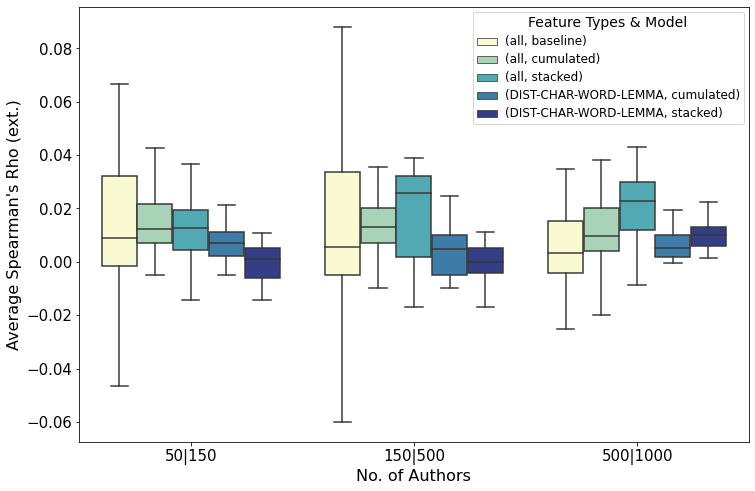

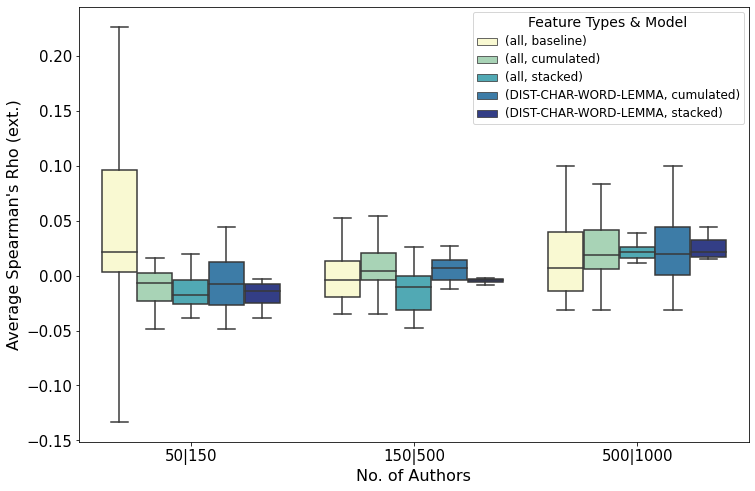

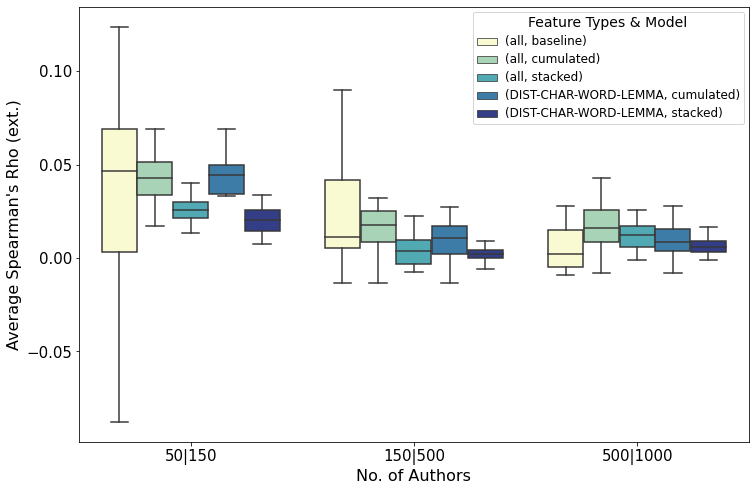

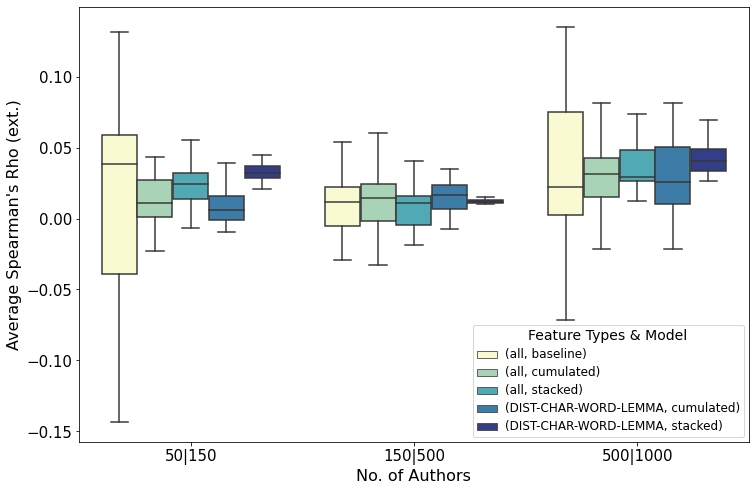

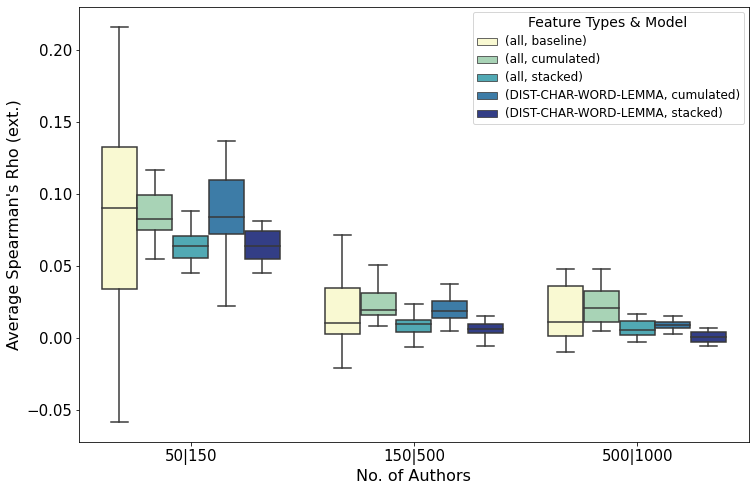

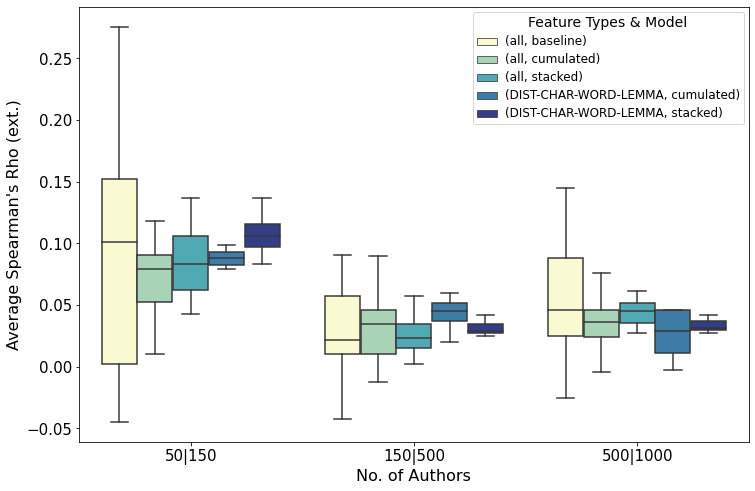

In [97]:
for group in grouped.groups.keys():
    #gr2= grouped.get_group(group).groupby(by=['set', 'modeltype', 'No. of Authors'], as_index=False).mean()
    gr2 = grouped.get_group(group)
    gr2.loc[:, ['Feature Types & Model']] = gr2.apply(lambda x: '({}, {})'.format(str(x['set_feat']), x['modeltype']), axis=1)
    #print(np.unique(gr2['Feature Set & Model']))
    #print(gr2.head())
    fig, ax = plt.subplots(figsize=(12,8))
    #print(gr2.head())
    #sel = (gr2["Average Spearman's Rho (ext.)"]>= -0.15) & (gr2["Average Spearman's Rho (ext.)"]<=0.15)
    sel = [True for _ in range(gr2.shape[0])]
    #print(gr2.loc[sel, : ].head())
    sns.boxplot(x='No. of Authors', y="Average Spearman's Rho (ext.)", hue='Feature Types & Model',
                   data=gr2.loc[sel, : ], #exclude outliers
                  palette=colors, dodge=True, ax=ax, showfliers=False,
                hue_order=list(colors.keys()))
    #ax.set_yscale('log')
    #fig.legend(loc='')

    ax.set_xticklabels(['50|150', '150|500', '500|1000'])
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=13)
    ax.set_ylabel("Average Spearman's Rho (ext.)", fontsize=16)
    ax.set_xlabel("No. of Authors", fontsize=16)
    plt.setp(ax.get_legend().get_texts(), fontsize='12')
    plt.setp(ax.get_legend().get_title(), fontsize='14')
    os.makedirs(os.path.join(savedir, '..', 'figures', str(group[1])), exist_ok=True)
    fig.savefig(os.path.join(savedir, '../figures', str(group[1]), 'spearman_ext_{}.pdf'.format(group[0])))
    #ax.yaxis.set_ticks([np.log10(x) for p in np.arange(-.1, 0.1) for x in np.linspace(10**p, 10**(p+1), 10)], minor=True)
    fig.show()


C:\Users\schubert\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-98-c07dc11c6ad2>:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\schubert\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilo

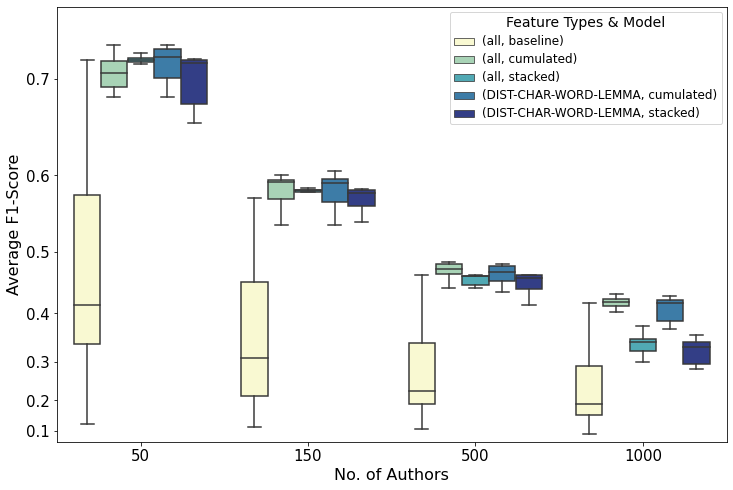

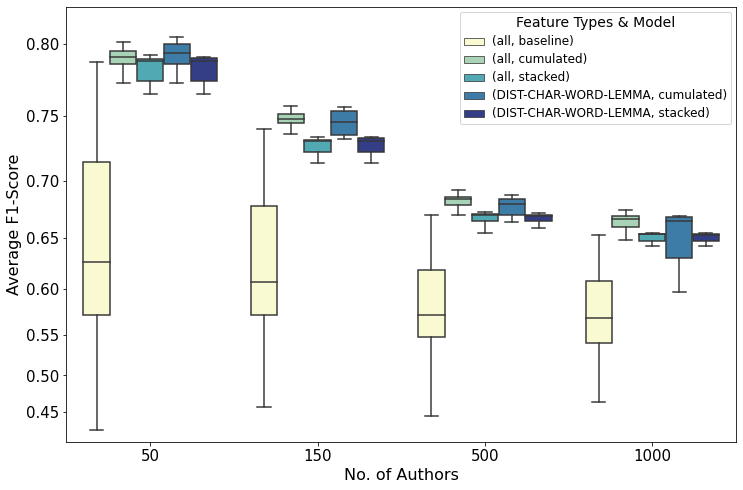

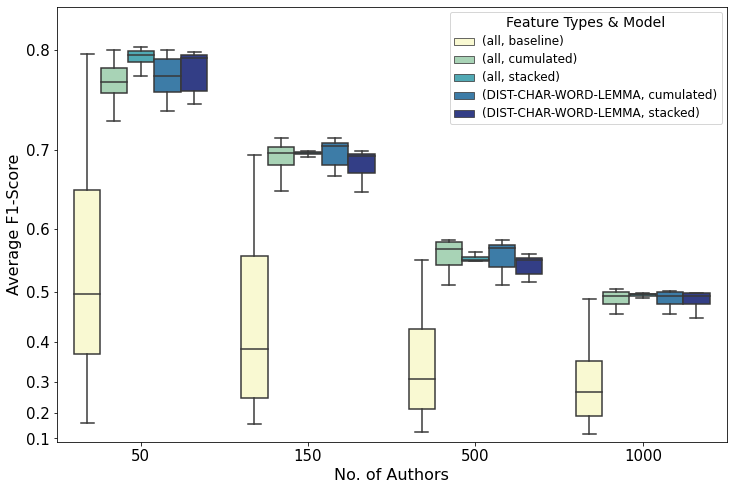

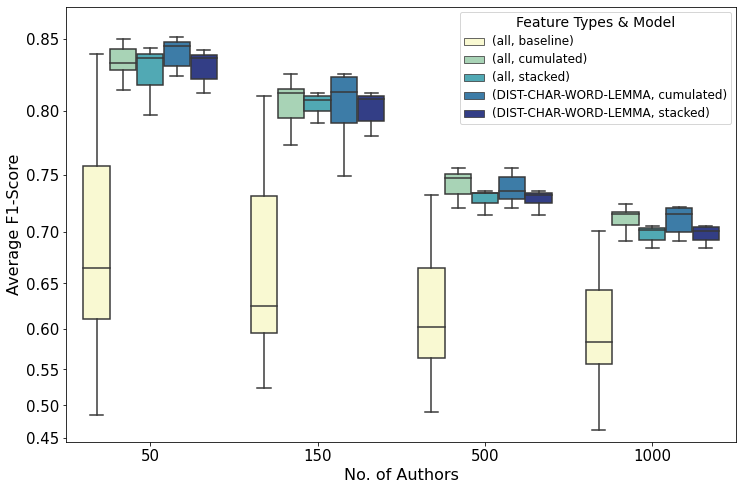

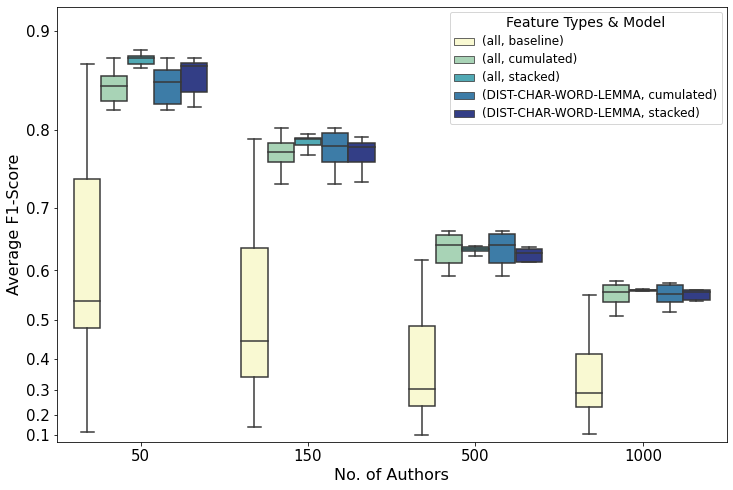

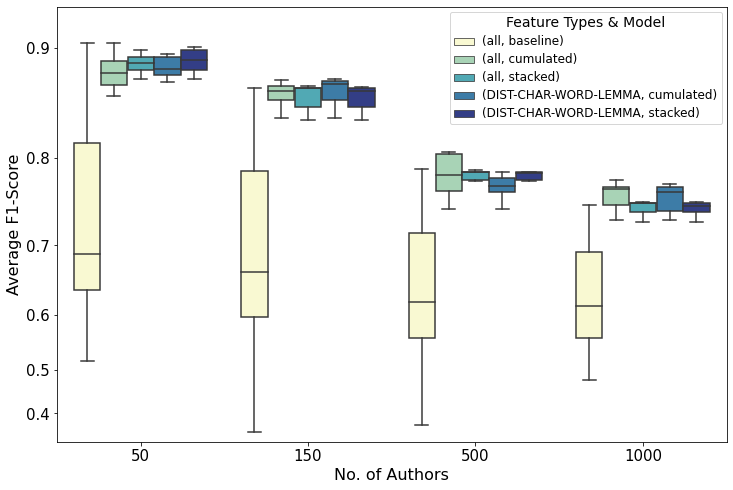

In [98]:
grouped = acc.copy(deep=True).dropna().groupby(by=['tweetLen', 'target'])
colors = {'(all, baseline)':"#ffffcc",
          '(all, cumulated)': "#a1dab4",
          '(all, stacked)':"#41b6c4",
          '(DIST-CHAR-WORD-LEMMA, cumulated)':"#2c7fb8",
          '(DIST-CHAR-WORD-LEMMA, stacked)':"#253494"}
exp = lambda x: 10**(x)
log = lambda x: np.log10(x)
for group in grouped.groups.keys():
    #gr2= grouped.get_group(group).groupby(by=['set', 'modeltype', 'No. of Authors'], as_index=False).mean()
    gr2 = grouped.get_group(group)
    gr2.loc[:, ['Feature Types & Model']] = gr2.apply(lambda x: '({}, {})'.format(str(x['set_feat']), x['modeltype']), axis=1).tolist()
    #print(gr2['Feature Set & Model'].unique())

    fig, ax = plt.subplots(figsize=(12,8))
    #print(gr2.head())
    #sel = (gr2["Average Spearman's Rho (ext.)"]>= -0.15) & (gr2["Average Spearman's Rho (ext.)"]<=0.15)
    sel = [True for _ in range(gr2.shape[0])]
    gr2 =gr2.loc[sel, : ]
    #print(gr2.loc[sel, : ].head())
    sns.boxplot(x='No. of Authors', y="f1-score", hue='Feature Types & Model',
                   data=gr2, #exclude outliers
                  palette=colors, dodge=True, ax=ax, showfliers=False,
                hue_order=list(colors.keys()))
    #ax.set_yscale('log')
    #fig.legend(loc='')
    ax.set_yscale('function', functions=(exp, log))
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=13)
    ax.set_ylabel("Average F1-Score", fontsize=16)
    ax.set_xlabel("No. of Authors", fontsize=16)
    plt.setp(ax.get_legend().get_texts(), fontsize='12')
    plt.setp(ax.get_legend().get_title(), fontsize='14')
    os.makedirs(os.path.join(savedir, '..', 'figures', str(group[1])), exist_ok=True)
    fig.savefig(os.path.join(savedir, '../figures', str(group[1]), 'f1_scores_{}.pdf'.format(group[0])))
    #ax.yaxis.set_ticks([np.exp(x) for p in range(0,1) for x in np.linspace(10**p, 10**(p+1), 10)], minor=True)
    fig.show()



